In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import joblib


In [15]:
# Load the structured datasets
med1 = pd.read_csv("medicine1.csv")
med2 = pd.read_csv("medicine2.csv")
otc = pd.read_csv("otc.csv")


In [16]:
# Fill missing values with "Unknown"
med1.fillna("Unknown", inplace=True)
med2.fillna("Unknown", inplace=True)
otc.fillna("Unknown", inplace=True)

# Reorder columns in OTC to match the structure of medicine1 and medicine2
otc = otc[['Product Name', 'Marketer', 'salt_composition', 'medicine_type', 'Product Form', 'mrp']]


C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\2648499162.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  med1.fillna("Unknown", inplace=True)
C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\2648499162.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  med2.fillna("Unknown", inplace=True)
C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\2648499162.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  otc.fillna("Unknown", inplace=True)


In [17]:
# Label all real entries as legitimate
med1['label'] = 1
med2['label'] = 1
otc['label'] = 1

# Combine into one legitimate dataset
df_legit = pd.concat([med1, med2, otc], ignore_index=True)


In [18]:
import random

fake_data = df_legit.sample(n=100000, random_state=42).copy()

# Safe convert MRP to float before corruption
fake_data['mrp'] = pd.to_numeric(fake_data['mrp'], errors='coerce').fillna(0.0)

def corrupt(value, corruption_list):
    return random.choice(corruption_list) if random.random() < 0.3 else value

fake_data['Marketer'] = fake_data['Marketer'].apply(lambda x: corrupt(x, ['XPharma', 'FakeCorp', 'ZGeneric']))
fake_data['mrp'] = fake_data['mrp'].apply(lambda x: x * random.uniform(0.2, 0.6))

fake_data['label'] = 0


In [19]:
# Combine legitimate and final version of fake data
df_final = pd.concat([df_legit, fake_data], ignore_index=True)



In [20]:
from sklearn.preprocessing import LabelEncoder

# Re-encode all text fields
le_name = LabelEncoder().fit(df_final['Product Name'])
le_marketer = LabelEncoder().fit(df_final['Marketer'])
le_salt = LabelEncoder().fit(df_final['salt_composition'])
le_type = LabelEncoder().fit(df_final['medicine_type'])
le_form = LabelEncoder().fit(df_final['Product Form'])

df_final['Product Name'] = le_name.transform(df_final['Product Name'])
df_final['Marketer'] = le_marketer.transform(df_final['Marketer'])
df_final['salt_composition'] = le_salt.transform(df_final['salt_composition'])
df_final['medicine_type'] = le_type.transform(df_final['medicine_type'])
df_final['Product Form'] = le_form.transform(df_final['Product Form'])


In [21]:
# Convert 'mrp' column to float, replacing errors with 0.0
df_final['mrp'] = pd.to_numeric(df_final['mrp'], errors='coerce').fillna(0.0)


In [22]:
from sklearn.model_selection import train_test_split

X = df_final[['Product Name', 'Marketer', 'salt_composition', 'medicine_type', 'Product Form', 'mrp']]
y = df_final['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model with class weight balanced
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on test data
y_pred = rf_model.predict(X_test)

# Show results
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.9323233743880305
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.55      0.69     20050
           1       0.93      0.99      0.96    129263

    accuracy                           0.93    149313
   macro avg       0.92      0.77      0.82    149313
weighted avg       0.93      0.93      0.93    149313



In [30]:
import joblib

# Save updated model
joblib.dump(rf_model, "drug_legitimacy_model.pkl")

# Re-save all encoders
joblib.dump(le_name, "encoder_product_name.pkl")
joblib.dump(le_marketer, "encoder_marketer.pkl")
joblib.dump(le_salt, "encoder_salt.pkl")
joblib.dump(le_type, "encoder_type.pkl")
joblib.dump(le_form, "encoder_form.pkl")

print("✅ Model and encoders saved successfully.")


✅ Model and encoders saved successfully.


In [34]:
print("🔢 Total Rows:", df_final.shape[0])
print("🧾 Total Columns:", df_final.shape[1])
print("📊 Label Distribution:\n", df_final['label'].value_counts())
print("🚨 Missing Values:\n", df_final.isnull().sum())


🔢 Total Rows: 746564
🧾 Total Columns: 7
📊 Label Distribution:
 label
1    646564
0    100000
Name: count, dtype: int64
🚨 Missing Values:
 Product Name        0
Marketer            0
salt_composition    0
medicine_type       0
Product Form        0
mrp                 0
label               0
dtype: int64


C:\Users\Samhit\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


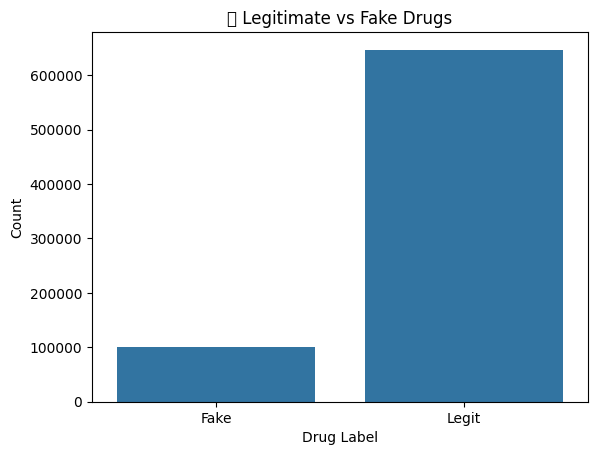

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df_final)
plt.title("🧪 Legitimate vs Fake Drugs")
plt.xticks([0, 1], ['Fake', 'Legit'])
plt.ylabel("Count")
plt.xlabel("Drug Label")
plt.show()


C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\1517606303.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_marketers, x='Product Count', y='Marketer Name', palette='crest')
C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\1517606303.py:21: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Samhit\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


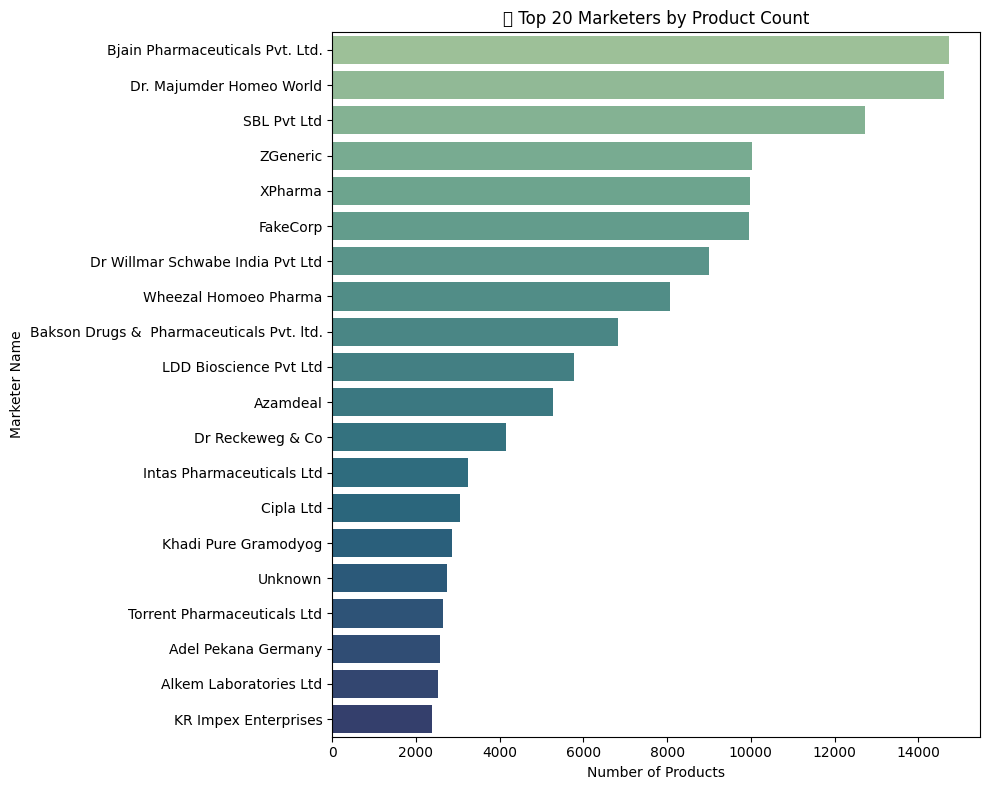

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the marketer label encoder
le_marketer = joblib.load("encoder_marketer.pkl")  # Adjust the path if needed

# Decode marketer codes in df_final
df_final['Marketer_Name'] = le_marketer.inverse_transform(df_final['Marketer'])

# Get top 20 marketers by count
top_20_marketers = df_final['Marketer_Name'].value_counts().head(20).reset_index()
top_20_marketers.columns = ['Marketer Name', 'Product Count']

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=top_20_marketers, x='Product Count', y='Marketer Name', palette='crest')
plt.title("🏭 Top 20 Marketers by Product Count")
plt.xlabel("Number of Products")
plt.ylabel("Marketer Name")
plt.tight_layout()
plt.show()


C:\Users\Samhit\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


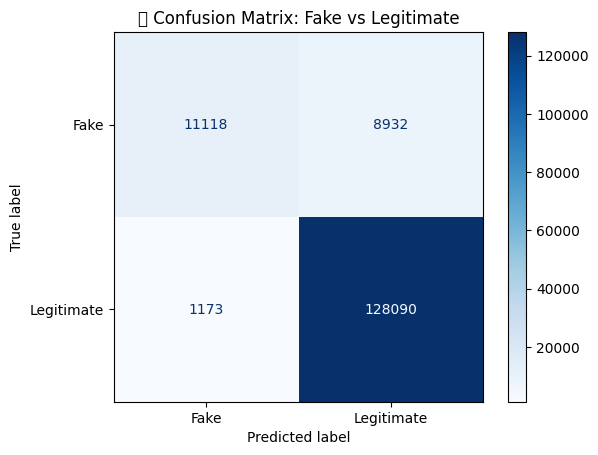

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Legitimate"])
disp.plot(cmap='Blues')
plt.title("🧪 Confusion Matrix: Fake vs Legitimate")
plt.show()


C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\704263982.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_final, palette='Set2')
C:\Users\Samhit\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


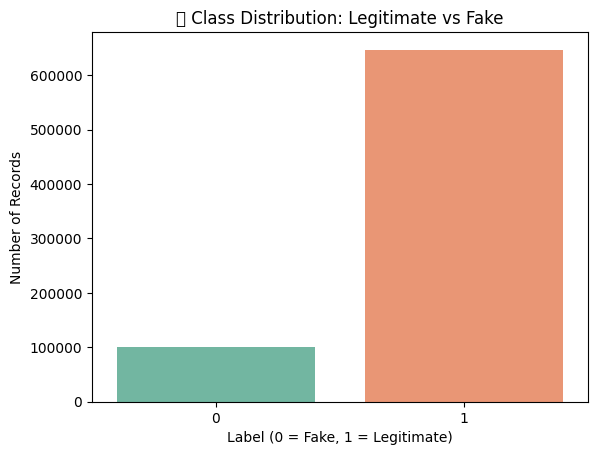

In [43]:
sns.countplot(x='label', data=df_final, palette='Set2')
plt.title("📦 Class Distribution: Legitimate vs Fake")
plt.xlabel("Label (0 = Fake, 1 = Legitimate)")
plt.ylabel("Number of Records")
plt.show()


C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\4042651416.py:14: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Samhit\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


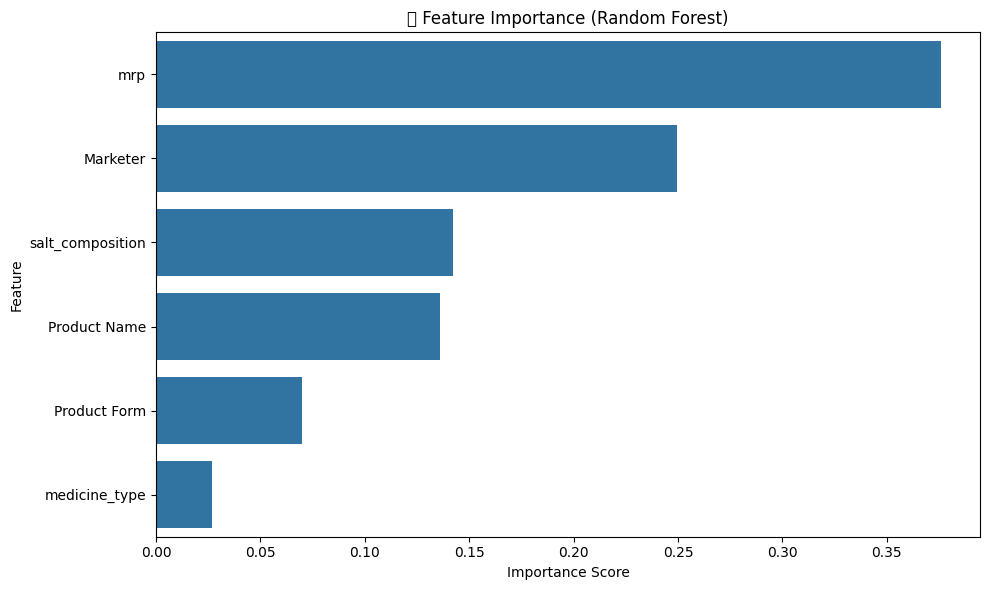

In [44]:
import numpy as np

importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("📌 Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\3870704344.py:10: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Samhit\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


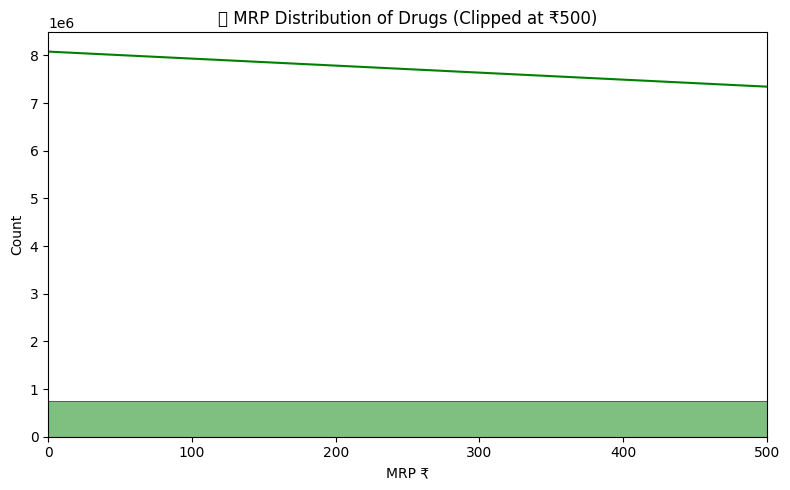

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_final['mrp'], bins=100, kde=True, color='green')
plt.xlim(0, 500)  # Limiting to ₹0–₹500 to improve visibility
plt.title("💰 MRP Distribution of Drugs (Clipped at ₹500)")
plt.xlabel("MRP ₹")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\2556248166.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_salts, x='Count', y='Salt Composition', palette='rocket')
C:\Users\Samhit\AppData\Local\Temp\ipykernel_1260\2556248166.py:18: UserWarning: Glyph 128138 (\N{PILL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Samhit\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128138 (\N{PILL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


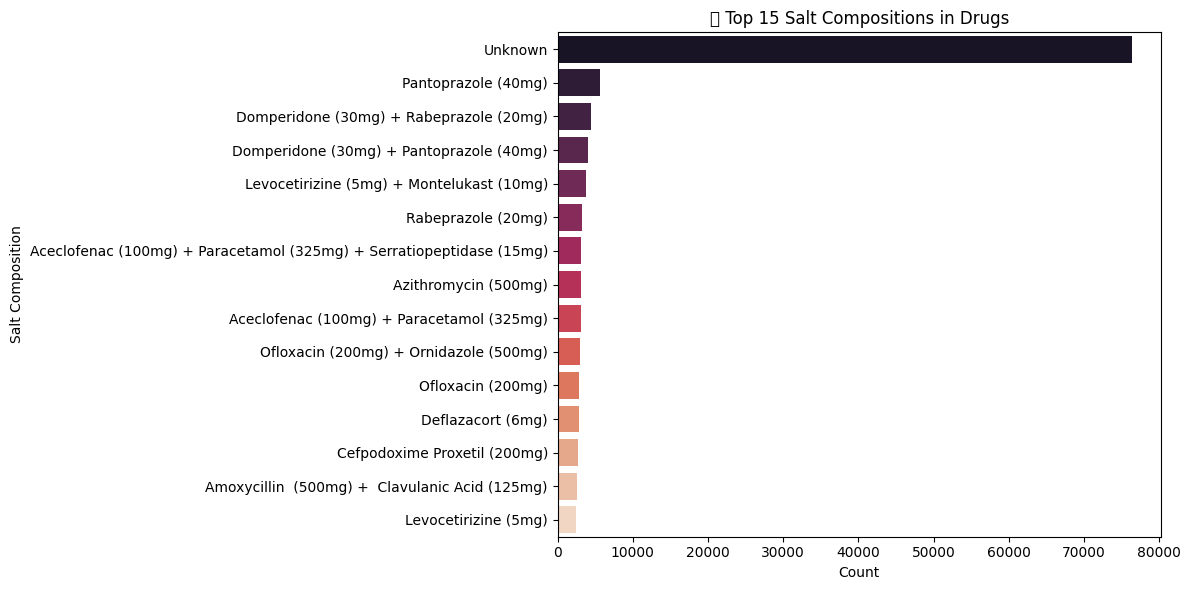

In [48]:
import joblib

# Load salt encoder (used during training)
le_salt = joblib.load("encoder_salt.pkl")

# Decode salt codes back to names
df_final['Salt_Decoded'] = le_salt.inverse_transform(df_final['salt_composition'])

# Plot top 15 salt compositions
top_salts = df_final['Salt_Decoded'].value_counts().head(15).reset_index()
top_salts.columns = ['Salt Composition', 'Count']

plt.figure(figsize=(12, 6))
sns.barplot(data=top_salts, x='Count', y='Salt Composition', palette='rocket')
plt.title("💊 Top 15 Salt Compositions in Drugs")
plt.xlabel("Count")
plt.ylabel("Salt Composition")
plt.tight_layout()
plt.show()
